# Predict loanword proportion use
Instead of predicting how often people use integrated loanwords, let's predict how often people use loanwords at all.

### Compute loanword proportions

In [1]:
import pandas as pd
import sys
if('..' not in sys.path):
    sys.path.append('..')
from data_processing.data_helpers import load_data_from_dirs
import re
# compute % of all posts with at least one loanword
loanword_data = pd.read_csv('../../data/mined_tweets/loanword_verb_posts_CLUSTER=twitter_posts_STARTDATE=2017_7_9_ENDDATE=2019_4_6.tsv', sep='\t')
loanword_data.rename(columns={'user_screen_name':'screen_name'}, inplace=True)
# let's also add the extra loanword data that we collected earlier
extra_loanword_data = pd.read_csv('../../data/mined_tweets/loanword_author_tweets_all_archives_extra_loanword_tweets.gz', sep='\t', compression='gzip')
data_dir = '../../data/mined_tweets/loanword_author_tweets_all_archives/'
file_matcher = re.compile('.+tweets\.gz')
use_cols = ['screen_name', 'id', 'lang', 'lang_score']
full_data = load_data_from_dirs([data_dir], file_matcher, use_cols=use_cols)

In [2]:
combined_loanword_data = pd.concat([loanword_data, extra_loanword_data], axis=0)
author_var = 'screen_name'
author_loanword_counts = combined_loanword_data.loc[:, author_var].value_counts()
author_post_counts = full_data.loc[:, author_var].value_counts() + author_loanword_counts
author_post_counts.dropna(inplace=True)
author_loanword_pct = author_loanword_counts / author_post_counts
author_loanword_pct.dropna(inplace=True)
print('%d/%d loanword authors'%(author_loanword_pct.shape[0], author_post_counts.shape[0]))
display(author_loanword_pct.head())

82142/82142 loanword authors


0001101011001E     0.500000
0001Sunshine       0.500000
000822e5bc974e0    0.000899
0009_bts           0.400000
000I00I            0.066667
Name: screen_name, dtype: float64

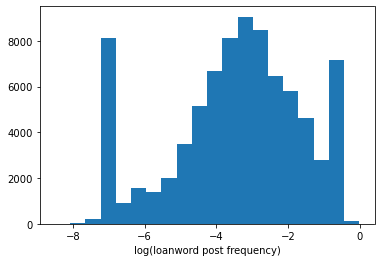

In [120]:
# plot distribution of dependent variable
# how many loanword authors use more/less loanwords?
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.hist(np.log(author_loanword_pct), bins=20)
plt.xlabel('log(loanword post frequency)')
plt.show()

OK! Most people post loanwords very rarely (1/20 posts).

How does this distribution look for just the high activity authors?

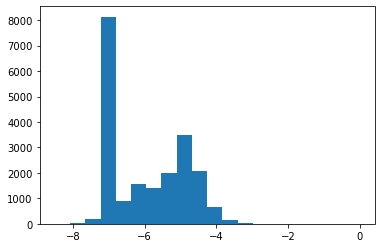

In [4]:
import numpy as np
post_cutoff = np.percentile(author_post_counts, 75)
# post_cutoff = 10
active_authors = author_post_counts[author_post_counts >= post_cutoff].index
active_author_loanword_pct = author_loanword_pct[author_loanword_pct.index.isin(active_authors)]
plt.hist(np.log(active_author_loanword_pct), bins=20)
plt.show()

Highly active authors tend to use relatively fewer loanwords, e.g. 1/150 posts.

### Predict proportion use

Let's predict loanword % use under the following conditions:
- all verb forms
- integrated verbs
- light verbs

In [15]:
from model_helpers import label_rare_data_var
author_social_data = pd.read_csv('../../data/mined_tweets/loanword_authors_combined_full_social_data.tsv', sep='\t')
# add dependent var
author_var = 'screen_name'
author_loanword_pct_df = author_loanword_pct.reset_index().rename(columns={'index':author_var, author_var:'loanword_pct'})
author_social_data = pd.merge(author_social_data, author_loanword_pct_df, on=author_var)
author_social_data.fillna('', inplace=True)
# add frequent categorical variables
fixed_effect_vars = ['screen_name']
min_count = 5
for fixed_effect_var in fixed_effect_vars:
    author_social_data = label_rare_data_var(author_social_data, fixed_effect_var, min_count)
display(author_social_data.head())

,screen_name,description_location_region,es,total_video_count,latin_american_artist_video_count,us_american_artist_video_count,latin_american_artist_video_pct,total_music_count,latin_american_music_genre_pct,latin_american_music_genre_count,...,log_integrated_verb_pct,log_post_pct,log_URL_share_pct,log_RT_pct,log_balanced_latin_american_media_pct,es_bin,latin_american_media_pct_bin,balanced_latin_american_media_pct_bin,loanword_pct,freq_screen_name
0,mariamunozzzzzz,europe,0.893475,,,,,,,,...,0.00995033,0.432355,-3.931912,-2.988840,,es_mid,,,0.000956,RARE
1,eleytricaa,europe,1,,,,,,,,...,0.00995033,-0.985203,-4.605170,-1.101675,,es_high,,,0.008197,RARE
2,ebonyyojd,europe,1,,,,,,,,...,,-1.614684,-4.605170,-0.052914,,es_high,,,0.007634,RARE
3,dguzmaan__,europe,1,,,,,,,,...,,-2.285571,-4.605170,-0.222740,,es_high,,,0.015873,RARE
4,miryam_olivera,europe,1,,,,,,,,...,-4.60517,-3.352407,-4.605170,-0.788680,,es_high,,,0.100000,RARE


Let's try linear regression to start.

In [55]:
from statsmodels.genmod.generalized_linear_model import GLM
from model_helpers import compute_err_data
from sklearn.preprocessing import StandardScaler
def compute_data_counts(data, scalar_vars, cat_vars):
    data_counts = []
    for scalar_var in scalar_vars:
        var_count = data.loc[:, scalar_var].mean()
        data_counts.append([scalar_var, var_count])
    for cat_var in cat_vars:
        var_count = data.loc[:, cat_var].value_counts()
        for cat_var_i, var_count_i in zip(var_count.index, var_count):
            data_counts.append([cat_var_i, var_count_i])
    data_count_idx, data_counts = zip(*data_counts)
    data_counts = pd.Series(data_counts, index=data_count_idx)
    return data_counts

def run_regression(data, dep_var, scalar_vars, cat_vars, cat_var_treatment_lookup, verbose=False):
    """
    Filter valid data and run regression.
    """
    scalar_var_str = '+'.join(scalar_vars)
    cat_var_with_treatment = list(map(lambda x: 'C(%s, Treatment("%s"))'%(x, cat_var_treatment_lookup[x]), cat_vars))
    cat_var_str = '+'.join(cat_var_with_treatment)
    indep_var_str_list = list(filter(lambda x: x!='', [scalar_var_str, cat_var_str]))
    indep_var_str = '+'.join(indep_var_str_list)
    formula = f'{dep_var} ~ {indep_var_str}'
    if(verbose):
        print(f'formula = {formula}')
    filter_vars = scalar_vars + cat_vars + [dep_var]
    valid_data = data.copy()
    for filter_var in filter_vars:
        valid_data = valid_data[valid_data.loc[:, filter_var]!='']
    # rescale scalar variables
    scaler = StandardScaler()
    for scalar_var in scalar_vars:
        valid_data = valid_data.assign(**{scalar_var : valid_data.loc[:, scalar_var].astype(float)})
        valid_data = valid_data.assign(**{scalar_var : scaler.fit_transform(valid_data.loc[:, scalar_var].values.reshape(-1,1))})
    model = GLM.from_formula(formula, data=valid_data)
    model_results = model.fit(method='lbfgs')
#     L2_wt = 0.1
#     model_results = model.fit_regularized(alpha=L2_wt, L1_wt=0.)
    # show data results
    data_counts = compute_data_counts(valid_data, scalar_vars, cat_vars)
    print(data_counts)
    # show model results
    try:
        display(model_results.summary())
    except Exception as e:
        model_results = compute_err_data(model_results)
        pass
    return model_results

In [56]:
dep_var = 'loanword_pct'
scalar_var_list = [
    ['log_es'],
    ['log_es'],
    ['log_integrated_verb_pct', 'log_post_pct', 'log_RT_pct', 'log_URL_share_pct'],
    ['log_integrated_verb_pct', 'log_post_pct', 'log_RT_pct', 'log_URL_share_pct']
]
cat_var_list = [
    [],
    ['description_location_region'],
    ['description_location_region', 'es_bin'],
    ['description_location_region', 'balanced_latin_american_media_pct_bin', 'es_bin'],
]
cat_var_treatment_val_lookup = {
    'es_bin' : 'es_low',
    'description_location_region' : 'UNK',
    'balanced_latin_american_media_pct_bin' : 'media_low'
}
for scalar_vars, cat_vars in zip(scalar_var_list, cat_var_list):
    model_results = run_regression(author_social_data, dep_var, scalar_vars, cat_vars, cat_var_treatment_val_lookup, verbose=True)
#     display(model_results)
#     break

formula = loanword_pct ~ log_es


/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


log_es    5.888707e-17
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           loanword_pct   No. Observations:                33906
Model:                            GLM   Df Residuals:                    33904
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                       0.0018837
Method:                         lbfgs   Log-Likelihood:                 58262.
Date:                Sat, 30 May 2020   Deviance:                       63.866
Time:                        18:35:37   Pearson chi2:                     63.9
No. Iterations:                     0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0360      0.000    152.541      0.000       0.035       0.036
log_es         0.0069      0.000     29.068      0.000       0.006       0.007
==============================================================================
"""

formula = loanword_pct ~ log_es+C(description_location_region, Treatment("UNK"))


/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


log_es           3.076067e-17
UNK              1.432700e+04
latin_america    7.922000e+03
europe           1.616000e+03
us_america       6.460000e+02
other            2.050000e+02
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           loanword_pct   No. Observations:                24716
Model:                            GLM   Df Residuals:                    24710
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                       0.0018119
Method:                         lbfgs   Log-Likelihood:                 42953.
Date:                Sat, 30 May 2020   Deviance:                       44.772
Time:                        18:35:38   Pearson chi2:                     44.8
No. Iterations:                     0                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             0.0348      0.000     97.871      0.000       0.034       0.036
C(description_location_region, Treatment("UNK"))[T.europe]           -0.0015      0.001     -1.300      0.193      -0.004       0.001
C(description_location_region, Treatment("UNK"))[T.latin_america]     0.0009      0.001      1.472      0.141      -0.000       0.002
C(description_location_region, Treatment("UNK"))[T.other]             0.0025      0.003      0.846      0.397      -0.003       0.008
C(description_location_region, Treatment("UNK"))[T.us_america]        0.0040      0.002      2.318      0.020       0.001       0.007
log_es                                                                0.0067      0.000     24.526      0.000       0.006       0.007
=====================================================================================================================================
"""

formula = loanword_pct ~ log_integrated_verb_pct+log_post_pct+log_RT_pct+log_URL_share_pct+C(description_location_region, Treatment("UNK"))+C(es_bin, Treatment("es_low"))


/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


log_integrated_verb_pct    3.991253e-18
log_post_pct               7.982505e-18
log_RT_pct                 1.875889e-16
log_URL_share_pct         -3.272827e-16
UNK                        8.279000e+03
latin_america              4.587000e+03
europe                     9.050000e+02
us_america                 3.580000e+02
other                      1.130000e+02
es_high                    7.046000e+03
es_mid                     6.999000e+03
es_low                     1.970000e+02
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           loanword_pct   No. Observations:                14242
Model:                            GLM   Df Residuals:                    14231
Model Family:                Gaussian   Df Model:                           10
Link Function:               identity   Scale:                      0.00042348
Method:                         lbfgs   Log-Likelihood:                 35106.
Date:                Sat, 30 May 2020   Deviance:                       6.0266
Time:                        18:35:39   Pearson chi2:                     6.03
No. Iterations:                     0                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             0.0087      0.002      5.716      0.000       0.006       0.012
C(description_location_region, Treatment("UNK"))[T.europe]           -0.0002      0.001     -0.288      0.773      -0.002       0.001
C(description_location_region, Treatment("UNK"))[T.latin_america]     0.0016      0.000      4.092      0.000       0.001       0.002
C(description_location_region, Treatment("UNK"))[T.other]             0.0004      0.002      0.182      0.855      -0.003       0.004
C(description_location_region, Treatment("UNK"))[T.us_america]     4.029e-05      0.001      0.036      0.971      -0.002       0.002
C(es_bin, Treatment("es_low"))[T.es_high]                             0.0162      0.002     10.047      0.000       0.013       0.019
C(es_bin, Treatment("es_low"))[T.es_mid]                             -0.0037      0.001     -2.445      0.014      -0.007      -0.001
log_integrated_verb_pct                                              -0.0007      0.000     -3.777      0.000      -0.001      -0.000
log_post_pct                                                         -0.0090      0.000    -35.062      0.000      -0.009      -0.008
log_RT_pct                                                           -0.0045      0.000    -18.496      0.000      -0.005      -0.004
log_URL_share_pct                                                    -0.0009      0.000     -3.691      0.000      -0.001      -0.000
=====================================================================================================================================
"""

formula = loanword_pct ~ log_integrated_verb_pct+log_post_pct+log_RT_pct+log_URL_share_pct+C(description_location_region, Treatment("UNK"))+C(balanced_latin_american_media_pct_bin, Treatment("media_low"))+C(es_bin, Treatment("es_low"))


/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


log_integrated_verb_pct   -3.504919e-17
log_post_pct              -8.443669e-17
log_RT_pct                 9.734117e-16
log_URL_share_pct          1.975500e-16
UNK                        6.350000e+02
latin_america              3.640000e+02
europe                     6.900000e+01
us_america                 3.400000e+01
other                      1.300000e+01
media_low                  5.030000e+02
media_high                 4.980000e+02
media_mid                  1.140000e+02
es_mid                     1.077000e+03
es_low                     2.800000e+01
es_high                    1.000000e+01
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           loanword_pct   No. Observations:                 1115
Model:                            GLM   Df Residuals:                     1102
Model Family:                Gaussian   Df Model:                           12
Link Function:               identity   Scale:                      6.5747e-07
Method:                         lbfgs   Log-Likelihood:                 6360.4
Date:                Sat, 30 May 2020   Deviance:                   0.00072453
Time:                        18:35:40   Pearson chi2:                 0.000725
No. Iterations:                     0                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================
                                                                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                          0.0010      0.000      6.112      0.000       0.001       0.001
C(description_location_region, Treatment("UNK"))[T.europe]                         0.0004      0.000      3.566      0.000       0.000       0.001
C(description_location_region, Treatment("UNK"))[T.latin_america]               8.009e-06   5.36e-05      0.149      0.881   -9.71e-05       0.000
C(description_location_region, Treatment("UNK"))[T.other]                         -0.0002      0.000     -0.945      0.345      -0.001       0.000
C(description_location_region, Treatment("UNK"))[T.us_america]                 -2.606e-05      0.000     -0.182      0.855      -0.000       0.000
C(balanced_latin_american_media_pct_bin, Treatment("media_low"))[T.media_high]  2.316e-05   5.17e-05      0.448      0.654   -7.82e-05       0.000
C(balanced_latin_american_media_pct_bin, Treatment("media_low"))[T.media_mid]  -6.244e-05   8.45e-05     -0.739      0.460      -0.000       0.000
C(es_bin, Treatment("es_low"))[T.es_high]                                        3.68e-05      0.000      0.121      0.904      -0.001       0.001
C(es_bin, Treatment("es_low"))[T.es_mid]                                           0.0002      0.000      1.414      0.157   -8.56e-05       0.001
log_integrated_verb_pct                                                         4.722e-05   2.45e-05      1.929      0.054   -7.63e-07    9.52e-05
log_post_pct                                                                   -5.083e-07   2.58e-05     -0.020      0.984   -5.12e-05    5.01e-05
log_RT_pct                                                                      1.658e-05   2.58e-05      0.641      0.521   -3.41e-05    6.72e-05
log_URL_share_pct                                                               1.496e-05   2.47e-05      0.606      0.544   -3.34e-05    6.33e-05
==================================================================================================================================================
"""

General findings:

- more Spanish-use authors use more loanwords
- Latin American authors use more loanwords
- people who share more and post more use fewer loanwords

To explain the Spanish finding: people who speak less Spanish may still discuss the same concepts addressed by the loanwords but do it with code-switching. 

E.g. "Yo Google it." is semantically the same as "Yo lo googleo."

### Predict loanword use with negative samples
Let's now sample authors who do not use any loanwords and test whether their lack of loanword use can be explained by any of the social factors mentioned.

We sample these authors from the existing Twitter data [here](../data_processing/collect_non_loanword_authors.py).

For the first pass we'll use the "easy" variables:
- URL sharing 
- RT sharing
- post frequency
- language use
- location
- native verb integration

In [24]:
import numpy as np
import pandas as pd
import re
import sys
if('..' not in sys.path):
    sys.path.append('..')
from importlib import reload
import data_processing.data_helpers
reload(data_processing.data_helpers)
from data_processing.data_helpers import load_data_from_dirs
# get all non-loanword tweets ;_;
data_dirs = ['../../data/mined_tweets/non_loanword_author_tweets/sample_authors/']
file_matcher = re.compile('.+tweets\.gz')
non_loanword_author_data = load_data_from_dirs(data_dirs, file_matcher=file_matcher)
non_loanword_author_data.fillna('', inplace=True)
# drop index col
if('Unnamed: 0' in non_loanword_author_data.columns):
    non_loanword_author_data.drop('Unnamed: 0', axis=1, inplace=True)
print(non_loanword_author_data.shape[0])
print('%d non-loanword authors'%(non_loanword_author_data.loc[:, 'screen_name'].nunique()))
# fix scalar vars?
scalar_vars = ['lang_score']
num_matcher = re.compile('^\d{2,}')
for scalar_var in scalar_vars:
    non_loanword_author_data = non_loanword_author_data[(non_loanword_author_data.loc[:, scalar_var].apply(lambda x: num_matcher.search(str(x)) is not None)) | 
                                                        (non_loanword_author_data.loc[:, 'lang_score']=='')]
    non_loanword_author_data = non_loanword_author_data.assign(**{scalar_var : non_loanword_author_data.loc[:, scalar_var].apply(lambda x: int(x) if x != '' else '')})
# non_loanword_author_data = pd.read_csv('../../data/mined_tweets/non_loanword_author_tweets/tmp.tsv', sep='\t')
# display(non_loanword_author_data.tail(10))
# display(non_loanword_author_data[non_loanword_author_data.loc[:, 'screen_name'].apply(lambda x: type(x) is float and np.isnan(x))])
# print(non_loanword_author_data.shape[0])

157633
10221 non-loanword authors


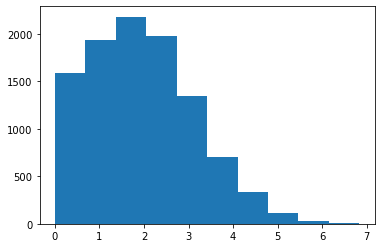

In [25]:
# how many posts per author
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
author_var = 'screen_name'
non_loanword_author_post_counts = np.log(non_loanword_author_data.loc[:, author_var].value_counts())
plt.hist(non_loanword_author_post_counts)
plt.show()

Most authors only post once. Let's restrict to the more active authors.

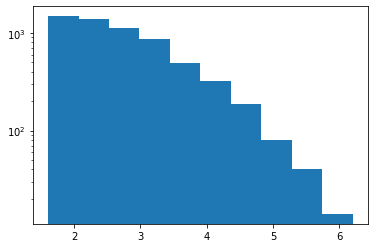

In [26]:
min_count = 5
max_count = 500 # get rid of spammers
non_loanword_author_post_counts = non_loanword_author_data.loc[:, author_var].value_counts()
active_non_loanword_author_post_counts = non_loanword_author_post_counts[(non_loanword_author_post_counts >= min_count) &
                                                                         (non_loanword_author_post_counts <= max_count)]
active_non_loanword_authors = active_non_loanword_author_post_counts.index
active_non_loanword_author_data = non_loanword_author_data[non_loanword_author_data.loc[:, author_var].isin(active_non_loanword_authors)]
plt.hist(np.log(active_non_loanword_author_post_counts))
plt.yscale('log')
plt.show()

In [ ]:
# let's get a sample of posts, tag each word for language and look for highly English words
## TODO: how to make this take less time??
# import numpy as np
# from langid.langid import LanguageIdentifier, model
# import sys
# if('..' not in sys.path):
#     sys.path.append('..')
# from data_processing.data_helpers import BasicTokenizer, clean_tweet_txt
# active_non_loanword_author_data = non_loanword_author_data[non_loanword_author_data.loc[:, author_var].isin(active_non_loanword_authors)]
# sample_size = 10000
# sample_data = active_non_loanword_author_data.loc[np.random.choice(active_non_loanword_author_data.index, sample_size, replace=False), :]
# txt_var = 'text'
# lang_id_model = LanguageIdentifier.from_modelstring(model, norm_probs=True)
# lang_long = 'spanish'
# TKNZR = BasicTokenizer(lang=lang_long)
# sample_data = sample_data.assign(**{
#     'text_tokens' : sample_data.loc[:, txt_var].apply(lambda x: TKNZR.tokenize(clean_tweet_txt(x)))
# })
# sample_data = sample_data.assign(**{
#     'text_token_lang' : sample_data.loc[:, 'text_tokens'].apply(lambda x: list(map(lambda y: lang_id_model.classify(y), x)))
# })

Extract language use.

64723/144755 original posts


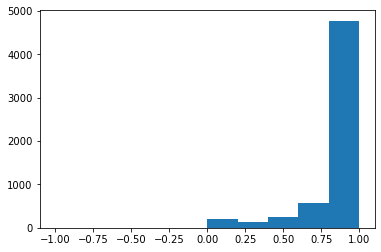

In [28]:
# extract language use
import re
def extract_lang_pct(data, lang='es', lang_score_min=90):
    data = data[data.loc[:, 'lang_score'] != '']
    high_score_data = data[data.loc[:, 'lang_score']>=lang_score_min]
    if(high_score_data.shape[0] > 0):
        lang_counts = high_score_data.loc[:, 'lang'].value_counts()
        if(lang in lang_counts.index):
            lang_pct = lang_counts.loc[lang] / lang_counts.sum()
        else:
            lang_pct = 0.
    else:
        lang_pct = -1
    return lang_pct
author_var = 'screen_name'
lang = 'es'
lang_score_min = 90
# filter to original content
non_original_matcher = re.compile('^RT @\w+')
original_active_non_loanword_author_data = active_non_loanword_author_data[active_non_loanword_author_data.loc[:, 'text'].apply(lambda x: non_original_matcher.search(x) is None)]
print('%d/%d original posts'%(original_active_non_loanword_author_data.shape[0], active_non_loanword_author_data.shape[0]))
author_lang_pct = original_active_non_loanword_author_data.groupby(author_var).apply(lambda x: extract_lang_pct(x, lang=lang, lang_score_min=lang_score_min))
# show distribution
plt.hist(author_lang_pct)
plt.show()
# recombine with author data
lang_pct_var = 'lang_pct'
author_lang_pct = author_lang_pct.reset_index().rename(columns={0:'lang_pct'})
if('lang_pct' not in active_non_loanword_author_data.columns):
    active_non_loanword_author_data = pd.merge(active_non_loanword_author_data, author_lang_pct, on=author_var, how='left')

OK! Most people tend to speak Spanish, makes sense.

In [36]:
location_var = 'user_location'
non_loanword_author_location_description = active_non_loanword_author_data[(active_non_loanword_author_data.loc[:, location_var] != '') & (active_non_loanword_author_data.loc[:, location_var].apply(lambda x: type(x) is str))].drop_duplicates('screen_name').drop_duplicates(location_var).loc[:, location_var].values
print(non_loanword_author_location_description[:10])

['Monterrey, Nuevo León' 'Barcelona' '#PES' 'EL SALVADOR'
 'Mar del Plata, Argentina' '☁.' 'Icon by Freepik: Flaticon.com' '696969'
 'Málaga, Andalucía y Ronda, ESP' 'Córdoba, Argentina']


Extract author location.

In [31]:
# extract location
# gazetteer data
geo_data_file = '/hg190/corpora/GeoNames/allCountriesSimplified.tsv'
geo_data = pd.read_csv(geo_data_file, sep='\t', index_col=False)
# state names
state_feat_code = 'ADM1'
us_geonames = geo_data[geo_data.loc[:, 'country']=='US']
us_state_geonames = us_geonames[us_geonames.loc[:, 'feature_code']==state_feat_code]
# get names and alternate name (2-letter state abbreve)
us_state_names = us_state_geonames.loc[:, 'name'].values.tolist()
state_abbreve_matcher = re.compile('[A-Z]{2}')
us_state_abbreve_names = us_state_geonames.loc[:, 'alternate_names'].apply(lambda x: list(filter(lambda y: state_abbreve_matcher.search(y) is not None, x.split(',')))[0]).values.tolist()
# combine, clean
us_state_names_combined = us_state_names + us_state_abbreve_names
us_state_names_combined = list(map(lambda x: x.lower(), us_state_names_combined))
# also add USA
us_state_names_combined += ['us', 'usa']
# country names
country_feat_code = 'PCLI'
country_geo_data = geo_data[geo_data.loc[:, 'feature_code']==country_feat_code]
country_names = list(country_geo_data.loc[:, 'name'].values)
country_codes = list(country_geo_data.loc[:, 'country'].values)
# add extra names
extra_country_names = ['Argentina', 'Brasil', 'Italy', 'Espana']
extra_country_codes = []
for country_name_i in extra_country_names:
    country_geo_data_i = country_geo_data[country_geo_data.loc[:, 'alternate_names'].apply(lambda x: country_name_i in x)].iloc[0, :]
    country_code_i = country_geo_data_i.loc['country']
    extra_country_codes.append(country_code_i)
country_names += extra_country_names
country_codes += extra_country_codes
# clean
prefix_country_matcher = re.compile('^.*republic of |^kingdom of |^state of ')
country_names = list(map(lambda x: x.lower(), country_names))
country_names = list(map(lambda x: prefix_country_matcher.sub('', x), country_names))
country_name_code_lookup = dict(zip(country_names, country_codes))
#     print(f'country names {country_names}')
# unambiguous cities
unambig_city_data_file = '../../data/control_var_data/unambig_city_data.tsv'
unambig_city_data = pd.read_csv(unambig_city_data_file, sep='\t', index_col=False)
unambig_city_data.rename(columns={'index' : 'name'}, inplace=True)
# remove bad vals
unambig_city_data = unambig_city_data[unambig_city_data.loc[:, 'name'].apply(lambda x: type(x) is str)]
# need at least 4 chars for a reasonable estimate
MIN_CITY_LEN = 4
unambig_city_data = unambig_city_data[unambig_city_data.loc[:, 'name'].apply(lambda x: len(x) > MIN_CITY_LEN)]
# get lookup
unambig_city_country_lookup = dict(zip(unambig_city_data.loc[:, 'name'].values, unambig_city_data.loc[:, 'country'].values))
# get location matchers
us_state_matcher = re.compile('|'.join(list(map(lambda x: f'(?<=,)\s?{x}$|^{x}$', us_state_names_combined))))
country_matcher = re.compile('|'.join(list(map(lambda x: f'(?<=,)\s?{x}$|^{x}$', country_names))))
unambig_city_matcher = re.compile('|'.join(unambig_city_data.iloc[:, 0].apply(lambda x: f'^{x}$')))

In [75]:
## extract country as closely as possible
## if location ends with US state => USA
## if location ends with country => country
## if location matches unambiguous city => country (e.g. "Houston" => USA)
## else "other"
import sys
if('..' not in sys.path):
    sys.path.append('..')
from importlib import reload
import data_processing.data_helpers
reload(data_processing.data_helpers)
from data_processing.data_helpers import match_location_region
location_regions = match_location_region(non_loanword_author_location_description, us_state_matcher, country_matcher, country_name_code_lookup, unambig_city_matcher, unambig_city_country_lookup, country_codes)
# rejoin with original data
author_location_var = 'user_location'
location_region_data = pd.DataFrame([location_regions, non_loanword_author_location_description], index=['location_region', author_location_var]).transpose()
if('location_region' not in active_non_loanword_author_data.columns):
    active_non_loanword_author_data = pd.merge(location_region_data, active_non_loanword_author_data, on=author_location_var, how='left')

In [76]:
print(active_non_loanword_author_data.loc[:, 'location_region'].value_counts())

UNK              87406
latin_america    63995
europe           17369
us_america        3403
other             1204
Name: location_region, dtype: int64


Extract post activity.

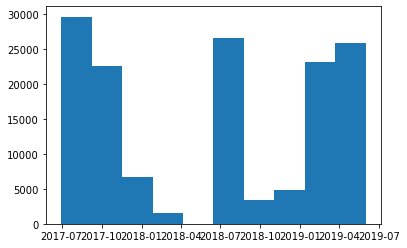

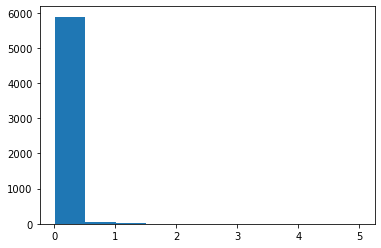

In [43]:
# extract post activity
# get dates
import data_processing.data_helpers
reload(data_processing.data_helpers)
from data_processing.data_helpers import clean_date_values
date_var = 'created_at'
clean_date_var = 'clean_date'
active_non_loanword_author_data = clean_date_values(active_non_loanword_author_data)
# remove null dates
active_non_loanword_author_data = active_non_loanword_author_data[active_non_loanword_author_data.loc[:, 'clean_date']!='']
# show date distribution
plt.hist(active_non_loanword_author_data.loc[:, clean_date_var])
plt.show()
# get activity
author_post_activity = active_non_loanword_author_data.groupby(author_var).apply(lambda x: x.shape[0] / ((x.loc[:, clean_date_var].max() - x.loc[:, clean_date_var].min()).days+1))
plt.hist(author_post_activity)
plt.show()
# combine with existing data
post_activity_var = 'post_activity'
author_post_activity = author_post_activity.reset_index().rename(columns={0 : post_activity_var})
if(post_activity_var not in active_non_loanword_author_data.columns):
    active_non_loanword_author_data = pd.merge(active_non_loanword_author_data, author_post_activity, on=author_var, how='left')

Extract content sharing.

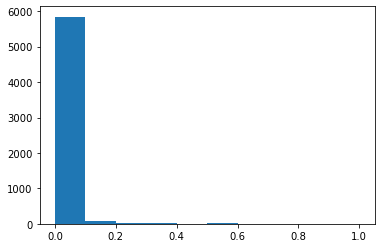

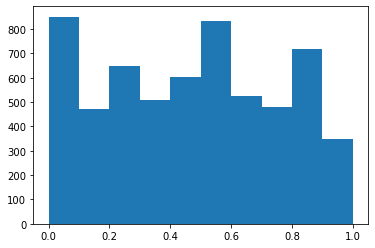

In [45]:
import re
URL_matcher = re.compile('https?://[\w \./]+|[a-z]+\.[a-z]+\.(com|org|net|gov)/[a-zA-Z0-9/\-_]+|')
clean_sub_matcher = re.compile('https?://|\s')
txt_var = 'text'
active_non_loanword_author_data = active_non_loanword_author_data.assign(**{
    'url_match' : active_non_loanword_author_data.loc[:, txt_var].apply(lambda x: clean_sub_matcher.sub('', URL_matcher.search(x).group(0)) if URL_matcher.search(x) is not None else '')
})
author_URL_pct = active_non_loanword_author_data.groupby(author_var).apply(lambda x: x[x.loc[:, 'url_match']!=''].shape[0] / x.shape[0])
share_matcher = re.compile('^RT:?\s?@\w+')
active_non_loanword_author_data = active_non_loanword_author_data.assign(**{
    'is_shared_content' : active_non_loanword_author_data.loc[:, txt_var].apply(lambda x: share_matcher.search(x) is not None)
})
author_share_pct = active_non_loanword_author_data.groupby(author_var).apply(lambda x: x.loc[:, 'is_shared_content'].sum() / x.shape[0])
## plot distributions
plt.hist(author_URL_pct)
plt.show()
plt.hist(author_share_pct)
plt.show()
## add to original data
URL_share_var = 'URL_pct'
RT_share_var = 'RT_pct'
author_URL_pct = author_URL_pct.reset_index().rename(columns={0 : URL_share_var})
author_share_pct = author_share_pct.reset_index().rename(columns={0 : RT_share_var})
if(URL_share_var not in active_non_loanword_author_data.columns):
    active_non_loanword_author_data = pd.merge(active_non_loanword_author_data, author_URL_pct, on=author_var, how='left')
if(RT_share_var not in active_non_loanword_author_data.columns):
    active_non_loanword_author_data = pd.merge(active_non_loanword_author_data, author_share_pct, on=author_var, how='left')

In [65]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from data_processing.data_helpers import conjugate_verb
from pandarallel import pandarallel
def conjugate_filter_verb(verb):
    # remove false positives, e.g. "preguntas" "paseo"
    banned_verb_forms = [verb.replace('ar', 'a'), verb.replace('ar', 'as'), verb.replace('ar', 'o')]
    verb_conjugations = conjugate_verb(verb)
    verb_conjugations = list(filter(lambda x: x not in banned_verb_forms, verb_conjugations))
    return verb_conjugations
def generate_start_mid_end(txt):
    return f'^{txt} | {txt} | {txt}$'
def extract_matches(txt, match_phrases, matchers):
    matches = []
    for match_phrase, matcher in zip(match_phrases, matchers):
        if(matcher.search(txt) is not None):
            matches.append(match_phrase)
    return matches
def extract_native_verb_use(post_data):
    # load native verbs
    native_verb_data_file = '../../data/loanword_resources/native_verb_light_verb_pairs.csv'
    native_verb_data = pd.read_csv(native_verb_data_file, sep=',')
    ## conjugate 
    # extract light verbs from phrase
    native_verb_data = native_verb_data.assign(**{
        'light_verb_VB' : native_verb_data.loc[:, 'light_verb'].apply(lambda x: x.split(' ')[0]),
        'light_verb_NP' : native_verb_data.loc[:, 'light_verb'].apply(lambda x: ' '.join(x.split(' ')[1:])),
    })
    # remove clitics for easier conjugation
    clitic_matcher = re.compile('se$')
    native_verb_data = native_verb_data.assign(**{
        'integrated_verb' : native_verb_data.loc[:, 'integrated_verb'].apply(lambda x: clitic_matcher.sub('', x)),
        'light_verb_VB' : native_verb_data.loc[:, 'light_verb_VB'].apply(lambda x: clitic_matcher.sub('', x)),
    })
    native_verb_data = native_verb_data.assign(**{
        'integrated_verb_matcher' : native_verb_data.loc[:, 'integrated_verb'].apply(lambda x: re.compile(generate_start_mid_end('(%s)'%('|'.join(conjugate_filter_verb(x)))))),
        'light_verb_matcher' : native_verb_data.apply(lambda x: re.compile(generate_start_mid_end('(%s) %s'%('|'.join(conjugate_verb(x.loc['light_verb_VB'])), x.loc['light_verb_NP']))), axis=1),
    })
    MAX_JOBS=10
    pandarallel.initialize(nb_workers=MAX_JOBS)
    integrated_verb_phrases = native_verb_data.loc[:, 'integrated_verb'].values
    integrated_verb_matchers = native_verb_data.loc[:, 'integrated_verb_matcher'].values
    clean_txt_var = 'text_clean'
    if(clean_txt_var not in post_data):
        post_data = post_data.assign(**{
            clean_txt_var : post_data.loc[:, 'text'].apply(lambda x: x.lower())
        })
    # integrated verbs
    print('about to extract integrated verbs')
    post_data = post_data.assign(**{
        'native_integrated_verb' : post_data.loc[:, clean_txt_var].parallel_apply(lambda x: extract_matches(x, integrated_verb_phrases, integrated_verb_matchers))
    })
    print('extracted all integrated verbs')
    # light verbs
    light_verb_phrases = native_verb_data.loc[:, 'light_verb'].values
    light_verb_matchers = native_verb_data.loc[:, 'light_verb_matcher'].values
    clean_txt_var = 'text_clean'
    print('about to extract light verbs')
    post_data = post_data.assign(**{
        'native_light_verb' : post_data.loc[:, clean_txt_var].parallel_apply(lambda x: extract_matches(x, light_verb_phrases, light_verb_matchers))
    })
    print('extracted all light verbs')
    # clean data
    # light verb supercedes integrated verb
    # e.g. "pedir disculpas" matches "diculpar" => only keep "pedir disculpas"
    native_light_integrated_verb_lookup = dict(native_verb_data.loc[:, ['light_verb', 'integrated_verb']].values)
    clean_post_data = []
    for i, data_i in post_data.iterrows():
        integrated_verbs_i = data_i.loc['native_integrated_verb']
        light_verbs_i = data_i.loc['native_light_verb']
        for light_verb_j in light_verbs_i:
            integrated_verb_j = native_light_integrated_verb_lookup[light_verb_j]
            if(integrated_verb_j in integrated_verbs_i):
                integrated_verbs_i.remove(integrated_verb_j)
        data_i.loc['native_integrated_verb'] = list(integrated_verbs_i)
        clean_post_data.append(data_i)
    clean_post_data = pd.concat(clean_post_data, axis=1).transpose()
    # only keep data with at least one native verb
    clean_post_data = clean_post_data[(clean_post_data.loc[:, 'native_light_verb'].apply(lambda x: len(x) > 0)) | (clean_post_data.loc[:, 'native_integrated_verb'].apply(lambda x: len(x) > 0))]

    ## organize data
    # per-post
    # author | text | post ID | native verb type | native verb category (integrated vs. light)
    post_data_vars = ['screen_name', 'id', 'text']
    native_verb_vars = ['native_integrated_verb', 'native_light_verb']
    all_data_vars = post_data_vars + native_verb_vars
    # TODO: parallel 
    #     def add_word_info(data, word_vars)
    # serial
    flat_native_post_data = []
    for idx, data_i in clean_post_data.iterrows():
        clean_data_i = data_i.loc[post_data_vars]
        for var_j in native_verb_vars:
            for verb_k in data_i.loc[var_j]:
                data_k = clean_data_i.copy()
                data_k.loc['native_word_category'] = var_j
                word_type = verb_k
                # map light verb -> native verb to make type the same (fixed effect!!)
                # e.g. "pedir disculpas" -> "disculpar"
                if(var_j == 'native_light_verb'):
                    word_type = native_light_integrated_verb_lookup[word_type]
                data_k.loc['native_word_type'] = word_type
                flat_native_post_data.append(data_k)
    flat_native_post_data = pd.concat(flat_native_post_data, axis=1).transpose()
    print('%d flat native verb data'%(flat_native_post_data.shape[0]))
    # per-author
    # author | native verb integration % | date
    author_var = 'screen_name'
    word_var = 'native_word_type'
    word_category_var = 'native_word_category'
    per_author_native_pct_data = flat_native_post_data.groupby([author_var, word_var]).apply(lambda x: (x.loc[:, word_category_var]=='native_integrated_verb').sum() / x.shape[0])
    print('%d per author per word data'%(per_author_native_pct_data.shape[0]))
    verb_pct_var = 'integrated_verb_pct'
    per_author_native_pct_data = per_author_native_pct_data.reset_index().rename(columns={0 : verb_pct_var})
    # get average per word
    per_author_mean_native_pct_data = per_author_native_pct_data.groupby(author_var).apply(lambda x: x.loc[:, verb_pct_var].mean()).reset_index().rename(columns={0 : verb_pct_var})
    return per_author_mean_native_pct_data

1.000000    3028
0.000000     117
0.666667       2
0.500000       2
Name: integrated_verb_pct, dtype: int64


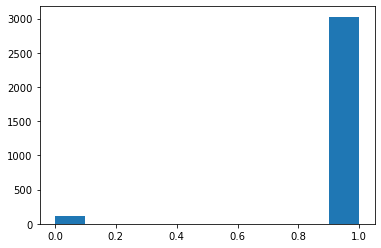

274225


In [67]:
# author_native_verb_pct = extract_native_verb_use(active_non_loanword_author_data)
verb_pct_var = 'integrated_verb_pct'
print(author_native_verb_pct.loc[:, verb_pct_var].value_counts())
plt.hist(author_native_verb_pct.loc[:, verb_pct_var])
plt.show()
# display(author_native_verb_pct.head())
# add to original data
author_var = 'screen_name'
if(verb_pct_var not in active_non_loanword_author_data.columns):
    active_non_loanword_author_data = pd.merge(active_non_loanword_author_data, author_native_verb_pct, on=author_var, how='left')
print(active_non_loanword_author_data.shape[0])

Great. Let's compare the social variable distributions between the non-loanword authors and the regular loanword authors.

In [78]:
# isolate the non-loanword author data (1 row / author)
author_var = 'screen_name'
per_author_non_loanword_data = active_non_loanword_author_data.drop_duplicates(author_var, inplace=False)
display(per_author_non_loanword_data.head())

,location_region,user_location,text,id,created_at,user_id,screen_name,lang,lang_score,user_description,file_dir,lang_pct,clean_date,post_activity,url_match,is_shared_content,URL_pct,RT_pct,native_word_type,integrated_verb_pct
0,UNK,"Monterrey, Nuevo León",Que será de mis días sin ellos ☹️☹️,895442502047723520,2017-08-10T00:31:43+00:00,1097202524,19Karladela,es,97,No estoy segura si pienso lo que escribo o esc...,sample_authors,1.000000,2017-08-10 00:31:43+00:00,0.027826,,False,0.0,0.312500,NaN,NaN
16,UNK,"Monterrey, Nuevo León",RT @moobeat: /Dev: Introducing Emotes https://...,895146392586420225,2017-08-09T04:55:05+00:00,1462455324,CuervoGamer94,en,98,Gamer de corazon y Amante de los Videojuegos M...,sample_authors,0.800000,2017-08-09 04:55:05+00:00,0.035821,,True,0.0,0.791667,NaN,NaN
38,UNK,"Monterrey, Nuevo León",Por ese hombre yo también las rompería. https:...,924784623900643328,2017-10-29T23:46:50+00:00,3075532057,IlenMtz,es,98,,sample_authors,1.000000,2017-10-29 23:46:50+00:00,0.027422,,False,0.0,0.200000,NaN,NaN
53,UNK,"Monterrey, Nuevo León",RT @NylonMag: Happy October 3rd 💕 https://t.co...,915300669212389376,2017-10-03T19:40:59+00:00,3288326030,LizethCortees1,en,98,Con Dios Todo es Posible.,sample_authors,0.833333,2017-10-03 19:40:59+00:00,0.019868,,True,0.0,0.500000,NaN,NaN
65,UNK,"Monterrey, Nuevo León",Te mereces que mañana si te quieran de verdad,1097355826849820673,2019-02-18T04:43:11+00:00,936068316350709760,NancyPC4,es,97,Cheerleader💅🏻,sample_authors,0.857143,2019-02-18 04:43:11+00:00,0.049217,,False,0.0,0.681818,NaN,NaN


In [100]:
## TODO: restrict to active loanword authors??
loanword_author_data = pd.read_csv('../../data/mined_tweets/loanword_authors_combined_full_social_data.tsv', sep='\t')
# cleanup
loanword_author_data.fillna('', inplace=True)
loanword_author_data.rename(columns={'es':'lang_pct', 'URL_share_pct' : 'URL_pct', 'description_location_region' : 'location_region'}, inplace=True)
display(loanword_author_data.head())
# loanword_author_data = loanword_author_post_data.drop_duplicates(author_var, inplace=False)

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,21,40,41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,screen_name,location_region,lang_pct,total_video_count,latin_american_artist_video_count,us_american_artist_video_count,latin_american_artist_video_pct,total_music_count,latin_american_music_genre_pct,latin_american_music_genre_count,...,log_latin_american_media_pct,log_media_URL_pct,log_integrated_verb_pct,log_post_pct,log_URL_share_pct,log_RT_pct,log_balanced_latin_american_media_pct,es_bin,latin_american_media_pct_bin,balanced_latin_american_media_pct_bin
0,noechenchual,europe,1,,,,,,,,...,,,0.00995033,-1.851733,-4.605170,-1.963012,,es_high,,
1,mariamunozzzzzz,europe,0.893475,,,,,,,,...,,,0.00995033,0.432355,-3.931912,-2.988840,,es_mid,,
2,soniamartin99,europe,1,,,,,,,,...,,,,-3.785206,-4.605170,0.009950,,es_high,,
3,eleytricaa,europe,1,,,,,,,,...,,,0.00995033,-0.985203,-4.605170,-1.101675,,es_high,,
4,claulovesshawn,europe,1,,,,,,,,...,,,,-2.340682,-4.605170,-0.066219,,es_high,,


In [118]:
from sklearn.preprocessing import StandardScaler
# combine data
author_data_vars = ['screen_name', 'location_region', 'lang_pct', 'RT_pct', 'URL_pct', 'post_pct', 'integrated_verb_pct', 'is_loanword_author']
active_non_loanword_author_data.rename(columns={'post_activity' : 'post_pct'}, inplace=True)
active_non_loanword_author_data = active_non_loanword_author_data.assign(**{
    'is_loanword_author' : 0,
})
loanword_author_data = loanword_author_data.assign(**{
    'is_loanword_author' : 1,
})
combined_author_data = pd.concat([loanword_author_data, active_non_loanword_author_data], axis=0)
author_var = 'screen_name'
combined_author_data.drop_duplicates(author_var, inplace=True)
combined_author_data = combined_author_data.loc[:, author_data_vars]
# log-transform scalar vars
import numpy as np
scalar_vars = ['lang_pct', 'RT_pct', 'URL_pct', 'post_pct', 'integrated_verb_pct']
smooth_val = 1e-2
for scalar_var in scalar_vars:
    combined_author_data = combined_author_data.assign(**{
        f'log_{scalar_var}' : combined_author_data.loc[:, scalar_var].apply(lambda x: np.log(x+smooth_val) if type(x) is float else x)
    })
# normalize scalar vars
scaler = StandardScaler()
for scalar_var in scalar_vars:
    log_scalar_var = f'log_{scalar_var}'
    scalar_vals = combined_author_data.loc[:, log_scalar_var].values
    valid_scalar_vals = np.where(scalar_vals != '')[0]
    norm_scalar_vals = scaler.fit_transform(scalar_vals[valid_scalar_vals].reshape(-1,1))[:, 0]
    scalar_vals[valid_scalar_vals] = norm_scalar_vals
    combined_author_data = combined_author_data.assign(**{
        log_scalar_var : scalar_vals
    })
display(combined_author_data.head())
print(combined_author_data.loc[:, 'is_loanword_author'].value_counts())
print(combined_author_data.shape[0])

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


,screen_name,location_region,lang_pct,RT_pct,URL_pct,post_pct,integrated_verb_pct,is_loanword_author,log_lang_pct,log_RT_pct,log_URL_pct,log_post_pct,log_integrated_verb_pct
0,noechenchual,europe,1,0.130435,0.000000,0.146965,1,1,0.169874,0.000000,0.000000,0.000000,0.18595
1,mariamunozzzzzz,europe,0.893475,0.040346,0.009606,1.530882,1,1,-0.273983,-2.988840,-3.931912,0.432355,0.18595
2,soniamartin99,europe,1,1.000000,0.000000,0.012704,,1,0.169874,0.009950,-4.605170,-3.785206,
3,eleytricaa,europe,1,0.322314,0.000000,0.363363,1,1,0.169874,-1.101675,-4.605170,-0.985203,0.18595
4,claulovesshawn,europe,1,0.925926,0.000000,0.086262,,1,0.169874,-0.066219,-4.605170,-2.340682,


1    82794
0     4458
Name: is_loanword_author, dtype: int64
87252


#### Negative samples: regression

Let's run this as a regression: can we predict whether an author tends to use loanwords or not?

In [119]:
from model_helpers import run_regularized_regression, filter_valid_data
dep_var = 'is_loanword_author'
cat_vars = ['location_region']
cat_var_treatment_lookup = {
    'location_region' : 'UNK'
}
scalar_vars = ['log_lang_pct', 'log_RT_pct', 'log_URL_pct', 'log_post_pct', 'log_integrated_verb_pct']
filter_vars = cat_vars + scalar_vars
reg_data = filter_valid_data(combined_author_data, filter_vars=filter_vars, scalar_vars=scalar_vars)
print(reg_data.shape[0])
print(reg_data.loc[:, dep_var].value_counts())
model, model_results = run_regularized_regression(reg_data, dep_var, scalar_vars=scalar_vars, cat_vars=cat_vars, cat_var_treatment_lookup=cat_var_treatment_lookup)
display(model_results)

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


29312
1    24854
0     4458
Name: is_loanword_author, dtype: int64


,mean,SE,Z,p,CI_lower,CI_upper
Intercept,0.124119,0.055205,2.248318,4.305406e-07,0.015919,0.232319
"C(location_region, Treatment(""UNK""))[T.europe]",0.008353,0.025581,0.326545,9.150812e-01,-0.041785,0.058492
"C(location_region, Treatment(""UNK""))[T.latin_america]",-0.003489,0.013950,-0.250106,9.501223e-01,-0.030830,0.023852
"C(location_region, Treatment(""UNK""))[T.other]",0.001836,0.069510,0.026412,9.994434e-01,-0.134401,0.138073
"C(location_region, Treatment(""UNK""))[T.us_america]",0.003986,0.041525,0.095984,9.926493e-01,-0.077401,0.085372
log_lang_pct,0.178607,0.010761,16.597381,0.000000e+00,0.157516,0.199699
log_RT_pct,-0.434668,0.005189,-83.763552,0.000000e+00,-0.444839,-0.424497
log_URL_pct,-0.475748,0.012062,-39.441990,0.000000e+00,-0.499389,-0.452107
log_post_pct,0.252282,0.004397,57.372656,0.000000e+00,0.243663,0.260900
log_integrated_verb_pct,0.042343,0.006723,6.297850,0.000000e+00,0.029165,0.055520


OK! People who use loanwords:
- use more Spanish
- share less content via RTs
- use fewer URLs
- post more frequently
- use more integrated verbs

This is weird! I would expect loanword authors to be more well-connected (more URLs, RTs) and less Spanish-centric (higher Spanish use use).

### Old code

In [88]:
# if('..' not in sys.path):
#     sys.path.append('..')
# from data_processing.data_helpers import execute_queries_all_instances
# # collect all posts from ES instance that are Spanish language with high confidence
query = {
    'query' : {
        'bool' : {
            'must' : [
                {
                    'match' : {
                        'lang' : 'es'
                    }
                },
                {
                    'range' : {
                        'lang_score' : {
                            'gte' : 90, 
                            'lte' : 100,
                        }
                    }
                }
            ]
        }
    }
}
es_queries = [query]
es_year_month_pairs=[(2017,7,9)]
es_cluster_name = 'twitter_posts'
keys_to_include = ['text', 'user_screen_name', 'lang', 'lang_score', 'user_description', 'user_location']
# query_results = execute_queries_all_instances(es_queries, es_year_month_pairs=es_year_month_pairs, es_cluster_name=es_cluster_name)
# remove all posts written by known loanword authors
# loanword_author_data = pd.read_csv('../../data/mined_tweets/loanword_verb_posts_CLUSTER=twitter_posts_STARTDATE=2017_7_9_ENDDATE=2019_4_6.tsv', sep='\t', usecols=['user_screen_name'])
# author_var = 'user_screen_name'
# loanword_authors = loanword_author_data.loc[:, author_var].unique()
# query_result_df = pd.DataFrame(query_results[0][0])
non_loanword_data = query_result_df[query_result_df.loc[:, 'user_screen_name'].isin(loanword_authors)]
print('%d non-loanword authors'%(non_loanword_data.loc[:, 'user_screen_name'].nunique()))


44892 non-loanword authors


In [71]:
# test how to extract negative sample authors from Elasticsearch
import pandas as pd
import sys
if('..' not in sys.path):
    sys.path.append('..')
from importlib import reload
from functools import reduce
import data_processing.data_helpers
reload(data_processing.data_helpers)
from data_processing.data_helpers import conjugate_light_verb, conjugate_verb, remove_ambiguous_verb_forms, generate_chunk_queries
loanword_data = pd.read_csv('../../data/loanword_resources/wiktionary_twitter_reddit_loanword_integrated_verbs_light_verbs.tsv', sep='\t')
# loanword_data = loanword_data.assign(**{
#     'light_verb_phrases' : loanword_data.loc[:, 'light_verb'].apply(conjugate_light_verb)
# })
loanword_data = loanword_data.assign(**{
    'integrated_verb_phrases' : loanword_data.loc[:, 'integrated_verb'].apply(conjugate_verb)
})
loanword_data = loanword_data.assign(**{
    'integrated_verb_phrases' : loanword_data.loc[:, 'integrated_verb_phrases'].apply(remove_ambiguous_verb_forms)
})
# get light verb noun
loanword_data = loanword_data.assign(**{
    'light_verb_noun' : loanword_data.loc[:, 'light_verb'].apply(lambda x: x.split(' ')[-1])
})
display(loanword_data.head())
# generate queries
# light_verb_queries = list(reduce(lambda x,y: x+y, loanword_data.loc[:, 'light_verb_phrases'].values))
integrated_verb_queries = list(reduce(lambda x,y: x+y, loanword_data.loc[:, 'integrated_verb_phrases'].values))
light_verb_nouns = loanword_data.loc[:, 'light_verb_noun'].values.tolist()
all_verb_queries = integrated_verb_queries + light_verb_nouns

extra_query_params = {
    'lang' : 'es',
}
chunk_queries = generate_chunk_queries(all_verb_queries, extra_query_params=extra_query_params)
# convert to negative
print(chunk_queries[0])

,loanword,integrated_verb,light_verb,integrated_verb_phrases,light_verb_noun
0,access,accesar,hacer|tener acces,"[accesé, accesamos, accesaste, accesasteis, ac...",acces
1,aim,aimear,hacer|tener aim,"[aimeé, aimeamos, aimeaste, aimeasteis, aimeó,...",aim
2,alert,alertear,hacer alert,"[alerteé, alerteamos, alerteaste, alerteasteis...",alert
3,audit,auditar,hacer (un) audit,"[audité, auditamos, auditaste, auditasteis, au...",audit
4,ban,banear,hacer un ban,"[baneé, baneamos, baneaste, baneasteis, baneó,...",ban


{'query': {'bool': {'must': [{'match': {'body': 'accesé|accesamos|accesaste|accesasteis|accesó|accesaron|accesamos|accesas|accesáis|accesan|accesaré|accesaremos|accesarás|accesaréis|accesará|accesarán|accesar|aimeé|aimeamos|aimeaste|aimeasteis|aimeó|aimearon|aimeo|aimeamos|aimeas|aimeáis|aimea|aimean|aimearé|aimearemos|aimearás|aimearéis|aimeará|aimearán|aimear|alerteé|alerteamos|alerteaste|alerteasteis|alerteó|alertearon|alerteo|alerteamos|alerteas|alerteáis|alertea|alertean|alertearé|alertearemos'}}, {'match': {'lang': 'es'}}]}}}
